# Optimal execution
## Probabilistic permanent price impact

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
%config InlineBackend.figure_format = "retina"

The price process is given by

$$
    S_{t+\Delta} = S_t + \sigma\,\sqrt{\Delta}\,B^{a_t}\,
$$

* $B^{a_t} \sim \text{Blli}(\text{sigmoid}(b a_t))$

In [13]:
def price_step(key, price_old, action, b):
    p = jax.nn.sigmoid(action * b)
    jump = jax.random.bernoulli(key, p)
    jump = (2 * jump - 1)
    
    price = price_old + jump
    
    return price

In [36]:
price_init = 100
T = 100
b = 0.1

key = jax.random.PRNGKey(3141)
key_action, keys_price = jax.random.split(key, 2)
keys_price = jax.random.split(keys_price, T)

def price_step_scan(price, state):
    key, action = state
    price = price_step(key, price, action, b)
    
    return price, price

In [ ]:
state = (keys_price, actions)

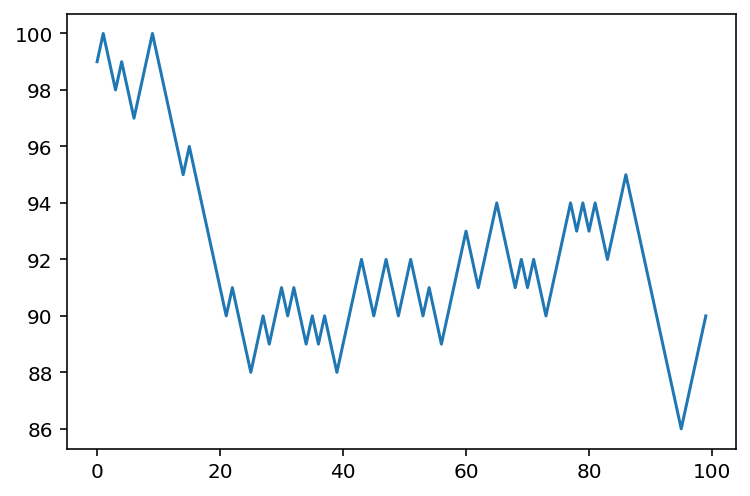

In [39]:
num_actions = 11
actions = jax.random.categorical(key_action, logits=jnp.ones(num_actions), shape=(T,)) - 5

state = (keys_price, actions)
_, price_hist = jax.lax.scan(price_step_scan, price_init, state)

plt.plot(price_hist)

In [41]:
actions

DeviceArray([ 2,  2, -5, -2,  3, -5, -2,  4,  4, -4, -4,  1,  0, -1, -4,
              5, -4, -3, -4, -4, -1,  0, -3, -4, -3,  3,  3,  2, -2, -1,
              1, -2,  4,  0,  1, -3, -2, -5, -4, -3,  5,  4,  3, -2,  0,
             -2, -5,  5, -3, -1,  4, -2,  5,  5,  5,  0, -3, -1, -2,  1,
             -1,  3,  2,  4,  3, -2, -5,  5, -3,  1, -1,  5, -3,  3,  4,
              1,  4,  4, -4,  4,  3,  5,  0, -1,  4,  3,  0,  4, -5, -5,
              3,  0,  5, -2,  5,  3, -1,  0,  4,  1], dtype=int32)

In [6]:
def sample_path(key, price_init, T, b):
    num_actions = 11
    key_action, keys_price = jax.random.split(key, 2)
    keys_price = jax.random.split(keys_price, T)

    actions = jax.random.categorical(key_action, logits=jnp.ones(num_actions), shape=(T,)) - 5
    state = (keys_price, actions)
    _, price_hist = jax.lax.scan(price_step_scan, price_init, state)
    
    return price_hist

sample_paths = jax.vmap(sample_path, in_axes=(0, None, None,b None))

In [11]:
num_paths = 100
keys = jax.random.split(key, num_paths)

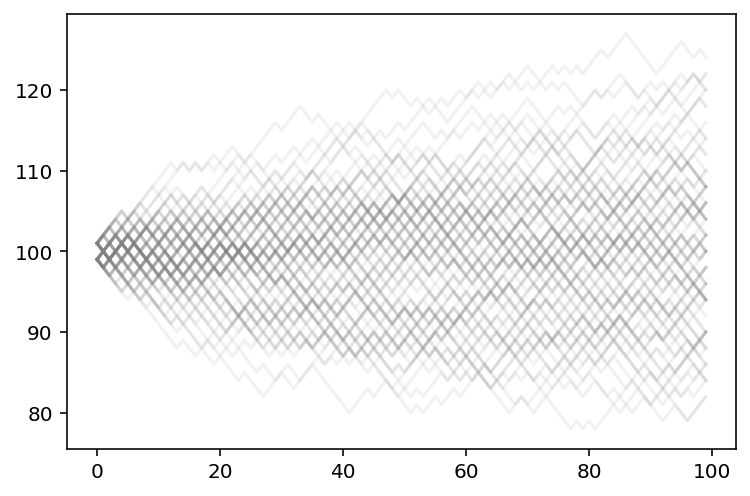

In [12]:
b = 0
plt.plot(sample_paths(keys, price_init, T, b).T, c="tab:gray", alpha=0.1);

## State-space
* Price: $(2N_T + 1)$
* Inventory $[-\tilde q, \tilde q]$ (because we want)
* Time: $[0, N_T]$

## Action-state
* Actions -> $a_1, a_2, \ldots, a_K\$

In [83]:
buy_min = -5
buy_max = 5

T = 100
inventory_size_min = -100
inventory_size_max = 100

policy_space = (2 * T + 1, # Size of price grid
                inventory_size_max - inventory_size_min + 1, # Size of inventory grid
                T, # time-steps
                buy_max - buy_min + 1) # number of actions
state_space = policy_space[:-1]


returns = jnp.zeros(policy_space)
counts = jnp.ones(policy_space)
Q = returns / counts

policy = jnp.zeros(state_space)
policy.shape

(201, 201, 100)

In [113]:
price_ix_to_value = {i: v for i,v in enumerate(range(-T, T + 1))}
inventory_ix_to_value = {i: v for i,v in enumerate(range(inventory_size_min, inventory_size_max + 1))}

price_value_to_ix = {v: i for i,v in price_ix_to_value.items()}
inventory_value_to_ix = {v: i for i,v in inventory_ix_to_value.items()}

In [148]:
def price_step(key, price_old, action, b):
    p = jax.nn.sigmoid(action * b)
    jump = jax.random.bernoulli(key, p)
    jump = (2 * jump - 1)
    
    price = price_old + jump
    
    return price

def episode_step(key, state_old, policy, b):
    price_ix, inventory_ix, time = state_old
    action = policy[state_old]
    
    # to-do: clean 🤮🤮
    price = price_ix + 
    inventory = inventory_ix_to_value[inventory_ix]
    
    new_inventory = jnp.clip(inventory + action, inventory_size_min, inventory_size_max)
    new_action = new_inventory - inventory
    new_price = price_step(key, price, new_action, b)
    new_time = time + 1
    
    
    values_new = {
        "price": new_price,
        "inventory": new_inventory,
        "time": new_time
    }
    
    state_new = [
        price_value_to_ix[new_price],
        inventory_value_to_ix[new_inventory],
        new_time
    ]
    
    return state_new, values_new

In [149]:
key = jax.random.PRNGKey(271)
key_price, key_inventory, key_action, keys_steps = jax.random.split(key, 4)
keys_steps = jax.random.split(keys_steps, T)

values_init = jnp.stack([
    jax.random.randint(key_price, (1,), -T, T),
    jax.random.randint(key_inventory, (1,), inventory_size_min, inventory_size_max),
    jnp.array([0]),
]).ravel()

action_init = jax.random.randint(key_action, (1,), buy_min, buy_max)

state_init = jnp.array([
    price_value_to_ix[values_init[0].item()],
    inventory_value_to_ix[values_init[1].item()],
    values_init[2]
])

state_init

DeviceArray([108,  12,   0], dtype=int32)

### Tod

In [ ]:
def episode_vmap_step(state_old, key):
    episode_step(key, state_old, policy, b)
    
jax.lax.scan(episode_vmap_step, state_init, keys_steps, )